In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.pardir)

In [3]:
import numpy as np
import joblib
from sklearn.decomposition import PCA

In [45]:
import matplotlib.pyplot as plt

# Create a general dataset, sample from it, reconstruct via different models and measure losses

In [49]:
from data.dataset import transform, random_crop
from utils.utils import segment_image, rescale_spectrogram

In [15]:
import h5py
import pickle

In [9]:
class songbird_random_sample(object):
    ''' For sampling random spectrograms from training/test id_list '''
    def __init__(self, path2idlist, external_file_path=[]):
        with open(path2idlist, 'rb') as f:
            self.id_list = pickle.load(f)
            self.external_file_path = external_file_path
            
    def __len__(self):
        # total number of samples
        return len(self.id_list)
    
    def get(self, nsamps=10000):
        # choose nsamp random files
        ids = np.random.permutation(np.arange(self.__len__()))
        
        X = []
        k = 0
        notdone = True
        while notdone:
            ID = self.id_list[ids[k]]
            
            if self.external_file_path:
                birdname = os.path.basename(ID['filepath'])
                f = h5py.File(os.path.join(self.external_file_path, birdname),'r')
            else:
                f = h5py.File(ID['filepath'], 'r')
            
            spect = np.array(f.get(ID['within_file']))
            f.close()
            
            segs = segment_image(spect, 16)
            segs = [transform(s) for s in segs]
            
            X += segs
            if len(X) > nsamps:
                notdone = False
            k += 1
        return X
    

extract data

In [12]:
dataset = songbird_random_sample(path2idlist='/home/gagan/data/zudeep/bird_hdfs/id_list_test.pkl', external_file_path='/home/gagan/data/zudeep/bird_hdfs/')

In [13]:
len(dataset)

76125

In [16]:
x = dataset.get(nsamps=70000)

In [53]:
len(x) # these are chunks

2064

In [54]:
x[0].shape

()

In [19]:
x_pca = [spect.flatten() for spect in x]

In [22]:
x_pca = np.stack(x_pca)
x_pca.shape

(70002, 2064)

In [55]:
x_orig = [x.reshape((129,16)) for x in x_pca]

# load a pca model

In [23]:
pca = joblib.load('/home/gagan/data/zudeep/models/nz_12_residual/2021-05-05_10-41-37.547480/pca_model.pkl')

In [25]:
pca = pca['pca_model']

In [26]:
W = pca.components_

In [27]:
W.shape

(256, 2064)

In [28]:
mu_pca = pca.mean_
std_pca = pca.noise_variance_

Text(0, 0.5, 'mean per dim')

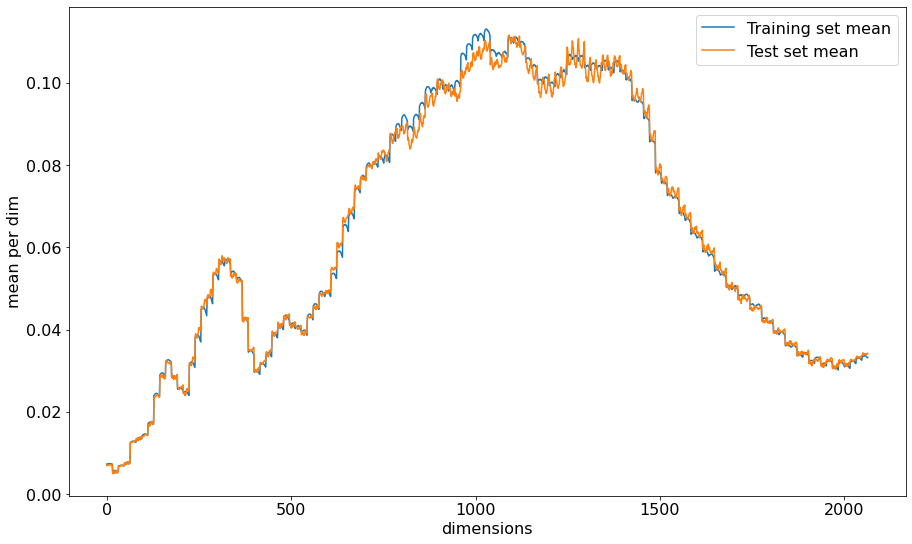

In [61]:
plt.figure(figsize=(15,9))
plt.plot(mu_pca)
plt.plot(mupca_local)
plt.legend(['Training set mean', 'Test set mean'])
plt.xlabel('dimensions')
plt.ylabel('mean per dim')

In [32]:
mu_tiled = np.tile(mu_pca, (x_pca.shape[0], 1))
mu_tiled.shape

(70002, 2064)

In [33]:
x2 = (x_pca - np.mean(x_pca,axis=0)) @ W.T
x2.shape

(70002, 256)

In [34]:
x_pca_recon = x2 @ W
x_pca_recon.shape

(70002, 2064)

In [42]:
mupca_local = np.mean(x_pca,axis=0)

In [62]:
x_pca_recon += np.tile(mupca_local,(x_pca_recon.shape[0], 1))

In [43]:
x_recon = []
for x in x_pca_recon:
    x_recon.append(x.reshape(129, 16) )

In [44]:
x_recon[0].shape

(129, 16)

# extract a portion for display

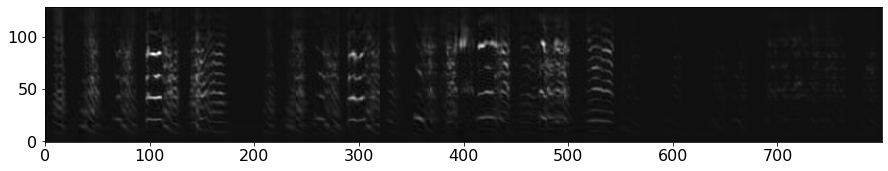

In [57]:
plt.figure(figsize=(15,6))
plt.imshow(np.concatenate(x_recon[:50],axis=1), origin='lower', cmap ='gray')

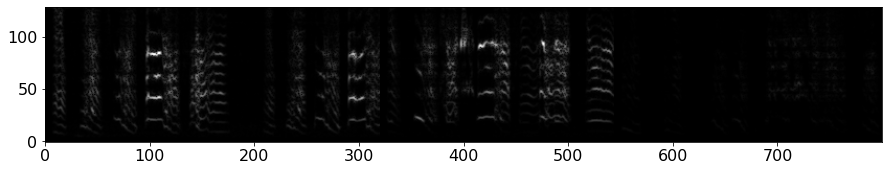

In [59]:
plt.figure(figsize=(15,6))
plt.imshow(np.concatenate(x_orig[:50],axis=1), origin='lower', cmap ='gray')

In [52]:
x[0].shape

()

# load neural networks

In [77]:
from utils.utils import load_netE, load_netG, overlap_decode, overlap_encode

In [79]:
help(overlap_decode)

Help on function overlap_decode in module utils.utils:

overlap_decode(Z, netG, noverlap=0, get_audio=False, cuda=True)
    Overlap decode. For a given numpy array Z of shape (timesteps , latent_dim)
    the output spectrogram (and optionally also audio) is created. 
    Params
    -------
        Z : numpy.ndarray, (timesteps , latent_dim)
        netG : generator neural network
        noverlap  : how much overlap (in spectrogram frames) between 
                    consecutive spectrogram chunks
        get_audio : bool, to generate audio using Griffin Lim
        cuda : bool, if True pushes computation on gpu
    Returns
    -------(timesteps , latent_dim)
        X : numpy.ndarray, (nfft bins , chunks)
        X_audio : numpy array, reconstructed audio



In [70]:
netG8 = load_netG('/home/gagan/data/zudeep/models/nz_8_residual/2021-05-04_16-37-45.247945/netG_epoch_6.pth', nz=8, ngf=128, cuda=True, resnet=True)
netE8 = load_netE('/home/gagan/data/zudeep/models/nz_8_residual/2021-05-04_16-37-45.247945/netE_epoch_6.pth', nz=8, ngf=128, cuda=True, resnet=True)

In [72]:
netG12 = load_netG('/home/gagan/data/zudeep/models/nz_12_residual/2021-05-05_10-41-37.547480/netG_epoch_6.pth', nz=12, ngf=128, cuda=True, resnet=True)
netE12 = load_netE('/home/gagan/data/zudeep/models/nz_12_residual/2021-05-05_10-41-37.547480/netE_epoch_6.pth', nz=12, ngf=128, cuda=True, resnet=True)

# encode and decode samples

currently, it isnt possible to encode and decode just one chunk

In [80]:
x_recon_8 = []
x_recon_12 = []

for x in x_orig:
    
    z8 = overlap_encode(x, netE8, transform_sample=False, imageW=16, noverlap=0, cuda=True)
    z12 = overlap_encode(x, netE12, transform_sample=False, imageW=16, noverlap=0, cuda=True)

    x_recon_8.append(overlap_decode(z8, netG8)[0].flatten())
    x_recon_12.append(overlap_encode(z12, netG12).flatten())
    

TypeError: expected np.ndarray (got numpy.float32)